<h2><b>The Fermi-Hubbard Model: Ground-State Energy Estimation</b></h2>
<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

<h3><u>1. Overview</u></h3>

This notebook demonstrates how `pyLIQTR` can perform qubitized ground-state energy estimation for the Fermi-Hubbard model.  Our target is a two-dimensional, single-band instance, which allows us to leverage resource-optimized encodings for fermionic Hamiltonians. A realistic workflow  also requires components initial state preparation $-$ a starting "guess" $-$ which may be the ground state of a classically-solvable quadratic / mean-field Hamiltonian.  These tasks are demonstrated in a separate notebook.

<hr></hr>

<h3><u>2. Background</u></h3>


The Fermi-Hubbard (FH) model is essentially a minimal treatment of electronic structure for periodic systems. While reductionistic, this model is believed to capture much of the physics underlying strong correlation. In this case, the electronic properties of a material are described by specifying one or more orbitals on each lattice site. Adjacent sites are coupled using tight-binding terms, while the Coulomb interaction is reduced to an on-site contact interaction between different spin channels.  The resulting Hamiltonian assumes a straightforward form:

\begin{equation}
H = \underbrace{-J\sum_{\langle p,q \rangle,\sigma} \left[c^\dagger_{p,\sigma} c_{q,\sigma} + c^\dagger_{q,\sigma} c_{p,\sigma}\right]}_{\text{Hopping}} + \underbrace{U \sum_{\langle p \rangle} n_{p,\uparrow} n_{p,\downarrow}}_{\text{Density Interaction}}.
\end{equation}

We have written this example for a single band, e.g., with one orbital per lattice site.  The first term in this Hamiltonian corresponds to a standard tight-binding model.  In the absence of interactions ($U = 0$) this  describes the propagation of fermions between sites at a rate determined by $J$.  The second term delivers a notorious degree of complexity - here, the parameter $U$ specifies the strength of many-body interactions.  These interations modulate the effective hopping rate while tuning on-site carrier and spin densities. Our notation labels the lattice sites using composite indices $p,q$ and introduces $\sigma \in \{\uparrow,\downarrow\}$ to denote the spin eigenstate (we can add an orbital index to $p,q$ in more complex arrangements).  Angle brackets denote summation over nearest-neighbor pairs, while the operators $c^\dagger_{p,\sigma}, c_{p,\sigma}$ describe the creation or annihilation of a spin-$\sigma$ fermion on the  $p$-th site.  The  $n_{k,\sigma} = c^\dagger_{k,\sigma} c_{k,\sigma}$ are the corresponding number operators.

While approximate, the Fermi-Hubbard Hamiltonian is believed to capture many important aspects of electronic correlation (such as the competition between electronic and magnetic orders).  Analytical and numerical results both suggest an intricate phase diagram for this model.  However, many theoretically efforts have been limited by inherent mathematical complexities or the exponential overhead required for precise numerical treatments.  It is nonetheless clear that the interaction strength  $U/J$ and doping fraction have a strong effect on the degree of many-body correlations and the nature of emergent phases. Indeed, prior efforts have suggested that these might span from Mott insulating and antiferromagnetic regimes to (non)-Fermi liquid behavior and unconventional superconducting states.  Verifying these assertions will likely require methods beyond classical computation.  

<hr>

<h3><u>3. Computational Methods</u></h3>

Our previous notebook introduced the Fermi-Hubbard model in terms of qubits.  We will not repeat those details, but instead focus on aspects of ground-state energy estimation (GSEE).  

Ground-state energy estimation is a particular limit of state preparation. Stated broadly, state preparation algorithms aim to converge initial wavefunction to a designated eigenstate of some Hamiltonian (up to a defined precision).  Our desired outputs will dictate algorithm selection: in some cases we only require an energy eigenvalue while  in others we must coherently prepare a state for subsequent calculations.  Our presentation will emphasize a Heisenberg-limited GSEE strategy that uses qubitization to achieve linear $T$-count scaling in problem size.  This method can also be made coherent for state preparation with subsequent oblivious amplitude amplification steps.

<h5><b>Ground-State Energy Estimation (GSEE)</b></h5>

The method implemented in `pyLIQTR` is based on [Phys. Rev. X <b>8</b>, 041015].

Many ground-state estimation protocols are based on the quantum phase estimation algorithm.  The algorithm here is no exception, though it queries powers of a qubitized walk $W$ operator in lieu of the standard time evolution oracle.  This operator contains a block encoding of our Hamiltonian $H$, which is handled using a $\text{Prepare}^{-1} \cdot \text{Select} \cdot \text{Prepare}$ oracle sequence. The eigenphases $\phi_k$ of $W$ have a simple functional relation with the eigenenergies $E_k$ of $H$,  allowing us to extract the latter using phase estimation:

\begin{equation}
\phi_k \approx e^{\imath \text{arccos} (E_k / \alpha) \cdot \hat{Y}}
\end{equation}

where $\alpha$ is a normalization factor that makes the block encoding unitary (i.e., actually we block-encode $H/\alpha$). 



 <center><img src="./figures/qubitized_phase_estimation.png" width=1100></img></center>


Phase readout is accomplished through a set of $d$ precision bits, either using a quantum Fourier transform or an iterative approach.  The number of required bits is related to the error in energy by,

\begin{equation}
d = {\biggl \lceil} \log \bigg(\frac{\sqrt{2} \pi \alpha}{2 \Delta E} \bigg)\biggr \rceil,
\end{equation}

where $\alpha$ is the normalization factor for the block encoding scheme.  Choosing the number of bits at or beyond this bound will give the desired precision.

<h3><u>4. Quantum Algorithms</u></h3>

`pyLIQTR` provides several quantum simulation methods can be used with the Fermi-Hubbard model.  We describe these and provide demonstration code below.

In [1]:

import  numpy                  as   np
import  matplotlib.pyplot      as   plt
import  cirq_ft.infra.testing  as   cirq_test

from    cirq_ft.infra.jupyter_tools  import  svg_circuit
from    scipy.optimize               import  curve_fit

## Circuit decomposition
##
from    pyLIQTR.utils.circuit_decomposition                   import   circuit_decompose_multi      

## Problem instance & Encoding items
##
from    pyLIQTR.ProblemInstances.getInstance                  import   getInstance
from    pyLIQTR.clam.lattice_definitions                      import   CubicLattice, SquareLattice, TriangularLattice
from    pyLIQTR.BlockEncodings.getEncoding                    import   getEncoding, VALID_ENCODINGS

## Walk operator and phase estimation
##
from    pyLIQTR.qubitization.qubitized_gates                  import   QubitizedWalkOperator
from    pyLIQTR.qubitization.phase_estimation                 import   QubitizedPhaseEstimation

## Resource analysis
##
from   pyLIQTR.utils.resource_analysis                        import   estimate_resources

## OpenQASM Export
##
from   pyLIQTR.utils.printing                                 import openqasm

<h4><b>4.1. GSEE Calculations: Introduction </b></h4> 


We will demonstrate how to assemble GSEE calculations for a three-dimensional Fermi-Hubbard instance.  We begin by instantiating the problem with $U/J = -4$ on a $3 \times 3$ lattice:

In [3]:
J      = -1.0;          N      =     3     
U      =  4.0;          shape  =  (N,N)

model  =  getInstance('FermiHubbard',shape=shape, J=J, U=U, cell=SquareLattice)

Next, we select a block encoding the Hamiltonian.  We will use the linear-$T$ scaling approach of (Phys. Rev. X <b>8</b>, 041015) which is invoked using the `VALID_ENCODINGS.FermiHubbardSquare` tag:

In [4]:
block_encoding    =  getEncoding(VALID_ENCODINGS.FermiHubbardSquare)(model)

This encoding is more intricate than a simple, Pauli-string based LCU.  The normalization factor is given by $\alpha = (2 J + U/2)N$ where $N = 2 N_x N_y$ is the number of orbitals considered in the model.  This factor is needed to recover eigenenergies after phase estimation:

In [5]:
block_encoding.alpha

36.0

The leading overhead from this method comes from the walk operator, which we can assemble and assess in isolation:

In [6]:
walk_operator  =  QubitizedWalkOperator( getEncoding(VALID_ENCODINGS.FermiHubbardSquare), instance=model)

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision.

In [6]:
resource_estimate_block  =  estimate_resources(block_encoding)
print(resource_estimate_block)

{'LogicalQubits': 32, 'T': 2346, 'Clifford': 5432}


In [7]:
resource_estimate_walk  =  estimate_resources(walk_operator)
print(resource_estimate_walk)

{'LogicalQubits': 33, 'T': 2402, 'Clifford': 5665}


Note that estimate resources has two keyword arguments that control $T$-synthesis.  The first is `rotation_gate_precision` (default `= 1e-10`), which specifies the maximum approximation error each rotation.  The second is `circuit_precision`, which overrides `rotation_gate_precision` if specified and sets the maximumum approximation error to `circuit_precision` / $N_\text{gates}$, where $N_\text{gates}$ is the number of rotation gates in a given circuit element.

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `cirq-ft` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show supported levels of decompositions:

In [8]:
circuit_decompose_multi(walk_operator.circuit,1) 

U: ──────────U───────────────────────────────R───
             │                               │
V: ──────────V───────────────────────────────R───
             │                               │
alpha: ──────alpha───────────────────────────R───
             │                               │
beta: ───────beta────────────────────────────R───
             │                               │
control: ────fermi_hubbard_square_encoding───@───
             │                               │
p_x0: ───────p_x─────────────────────────────R───
             │                               │
p_x1: ───────p_x─────────────────────────────R───
             │                               │
p_y0: ───────p_y─────────────────────────────R───
             │                               │
p_y1: ───────p_y─────────────────────────────R───
             │                               │
q_x0: ───────q_x─────────────────────────────R───
             │                               │
q_x1: ───────q_x─────────────────────────────R───
             │                               │
q_y0: ───────q_y─────────────────────────────R───
             │                               │
q_y1: ───────q_y─────────────────────────────R───
             │
target0: ────target──────────────────────────────
             │
target1: ────target──────────────────────────────
             │
target2: ────target──────────────────────────────
             │
target3: ────target──────────────────────────────
             │
target4: ────target──────────────────────────────
             │
target5: ────target──────────────────────────────
             │
target6: ────target──────────────────────────────
             │
target7: ────target──────────────────────────────
             │
target8: ────target──────────────────────────────
             │
target9: ────target──────────────────────────────
             │
target10: ───target──────────────────────────────
             │
target11: ───target──────────────────────────────
             │
target12: ───target──────────────────────────────
             │
target13: ───target──────────────────────────────
             │
target14: ───target──────────────────────────────
             │
target15: ───target──────────────────────────────
             │
target16: ───target──────────────────────────────
             │
target17: ───target──────────────────────────────
             │
temp0: ──────temp────────────────────────────────
             │
temp1: ──────temp────────────────────────────────

In [9]:
circuit_decompose_multi(walk_operator.circuit,2) 

U: ──────────PrepareHubbard───SelectHubbard───PrepareHubbard───@───
             │                │               │                │
V: ──────────V────────────────V───────────────V────────────────@───
             │                │               │                │
alpha: ──────alpha────────────alpha───────────alpha────────────@───
             │                │               │                │
beta: ───────beta─────────────beta────────────beta─────────────@───
             │                │               │                │
control: ────┼────────────────@───────────────┼────────────────Z───
             │                │               │                │
p_x0: ───────p_x──────────────p_x─────────────p_x──────────────@───
             │                │               │                │
p_x1: ───────p_x──────────────p_x─────────────p_x──────────────@───
             │                │               │                │
p_y0: ───────p_y──────────────p_y─────────────p_y──────────────@───
             │                │               │                │
p_y1: ───────p_y──────────────p_y─────────────p_y──────────────@───
             │                │               │                │
q_x0: ───────q_x──────────────q_x─────────────q_x──────────────@───
             │                │               │                │
q_x1: ───────q_x──────────────q_x─────────────q_x──────────────@───
             │                │               │                │
q_y0: ───────q_y──────────────q_y─────────────q_y──────────────@───
             │                │               │                │
q_y1: ───────q_y──────────────q_y─────────────q_y──────────────@───
             │                │               │
target0: ────┼────────────────target──────────┼────────────────────
             │                │               │
target1: ────┼────────────────target──────────┼────────────────────
             │                │               │
target2: ────┼────────────────target──────────┼────────────────────
             │                │               │
target3: ────┼────────────────target──────────┼────────────────────
             │                │               │
target4: ────┼────────────────target──────────┼────────────────────
             │                │               │
target5: ────┼────────────────target──────────┼────────────────────
             │                │               │
target6: ────┼────────────────target──────────┼────────────────────
             │                │               │
target7: ────┼────────────────target──────────┼────────────────────
             │                │               │
target8: ────┼────────────────target──────────┼────────────────────
             │                │               │
target9: ────┼────────────────target──────────┼────────────────────
             │                │               │
target10: ───┼────────────────target──────────┼────────────────────
             │                │               │
target11: ───┼────────────────target──────────┼────────────────────
             │                │               │
target12: ───┼────────────────target──────────┼────────────────────
             │                │               │
target13: ───┼────────────────target──────────┼────────────────────
             │                │               │
target14: ───┼────────────────target──────────┼────────────────────
             │                │               │
target15: ───┼────────────────target──────────┼────────────────────
             │                │               │
target16: ───┼────────────────target──────────┼────────────────────
             │                │               │
target17: ───┼────────────────target──────────┼────────────────────
             │                                │
temp0: ──────temp─────────────────────────────temp─────────────────
             │                                │
temp1: ──────temp─────────────────────────────temp^-1──────────────

Further decomposition further breaks down gates into simpler and simpler operations, though they also begin to introduce the "decompose_protocol" qubits, which are ancilla qubits used for the implementation of certain operators:

In [10]:
circuit_decompose_multi(walk_operator.circuit,3) 

┌───────────┐                                        ┌───────┐          ┌──────┐                                    ┌─────┐                               ┌────────┐                         ┌──┐
_decompose_protocol_29_c(0): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Anc───────Anc────
                                                                                                                                                                                                                                                                                                     │         │
_decompose_protocol_23_c(0): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────And───@──────────And†─────────────────────────────────────────────────────────────────────────────────────────┼─────────┼──────
                                                                                                                                                                                       │     │          │                                                                                            │         │
_decompose_protocol_21_c(0): ──────────────────────────────────────────────────────────────────────────And────@───────And†─────────────────────────────────────────────────────────────┼─────┼──────────┼────────────────────────────────────────────────────────────────────────────────────────────┼─────────┼──────
                                                                                                       │      │       │                                                                │     │          │                                                                                            │         │
_decompose_protocol_21_c(1): ──────────────────────────────────────────────────────────────────────────Anc────┼───────Anc──────────────────────────────────────────────────────────────┼─────┼──────────┼────────────────────────────────────────────────────────────────────────────────────────────┼─────────┼──────
                                                                                                       │      │       │                                                                │     │          │                                                                                            │         │
_decompose_protocol_29_c(1): ──────────────────────────────────────────────────────────────────────────┼──────┼───────┼────────────────────────────────────────────────────────────────┼─────┼──────────┼────────────────────────────────────────────────────────────────────────────────────────────Anc───────Anc────
                                                                                                       │      │       │                                                                │     │          │                                                                                            │         │
_decompose_protocol_23_c(1): ──────────────────────────────────────────────────────────────────────────┼──────┼───────┼────────────────────────────────────────────────────────────────Anc───┼──────────Anc──────────────────────────────────────────────────────────────────────────────────────────┼─────────┼──────
                                                                                                       │      │       │                                                                │     │          │                                                                                            │         │
_decompose_protocol_29_c(2): ──────────────────────────────────────────────────────────────────────────┼──────

---

It is equally straightforward to build the phase estimation circuit.  Our `QubitizedPhaseEstimation` gate handle this process for a given specification of the error target (keyword `eps=`) or a set number of precision bits (keyword `prec=`):

In [11]:
N_prec = 4
eps    = 1e-3

# gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.FermiHubbardSquare),
#                                       instance=model,eps=eps )

gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.FermiHubbardSquare),
                                      instance=model,prec=N_prec )

In [12]:
estimate_resources(gate_gsee)

{'LogicalQubits': 36, 'T': 19384, 'Clifford': 46281}

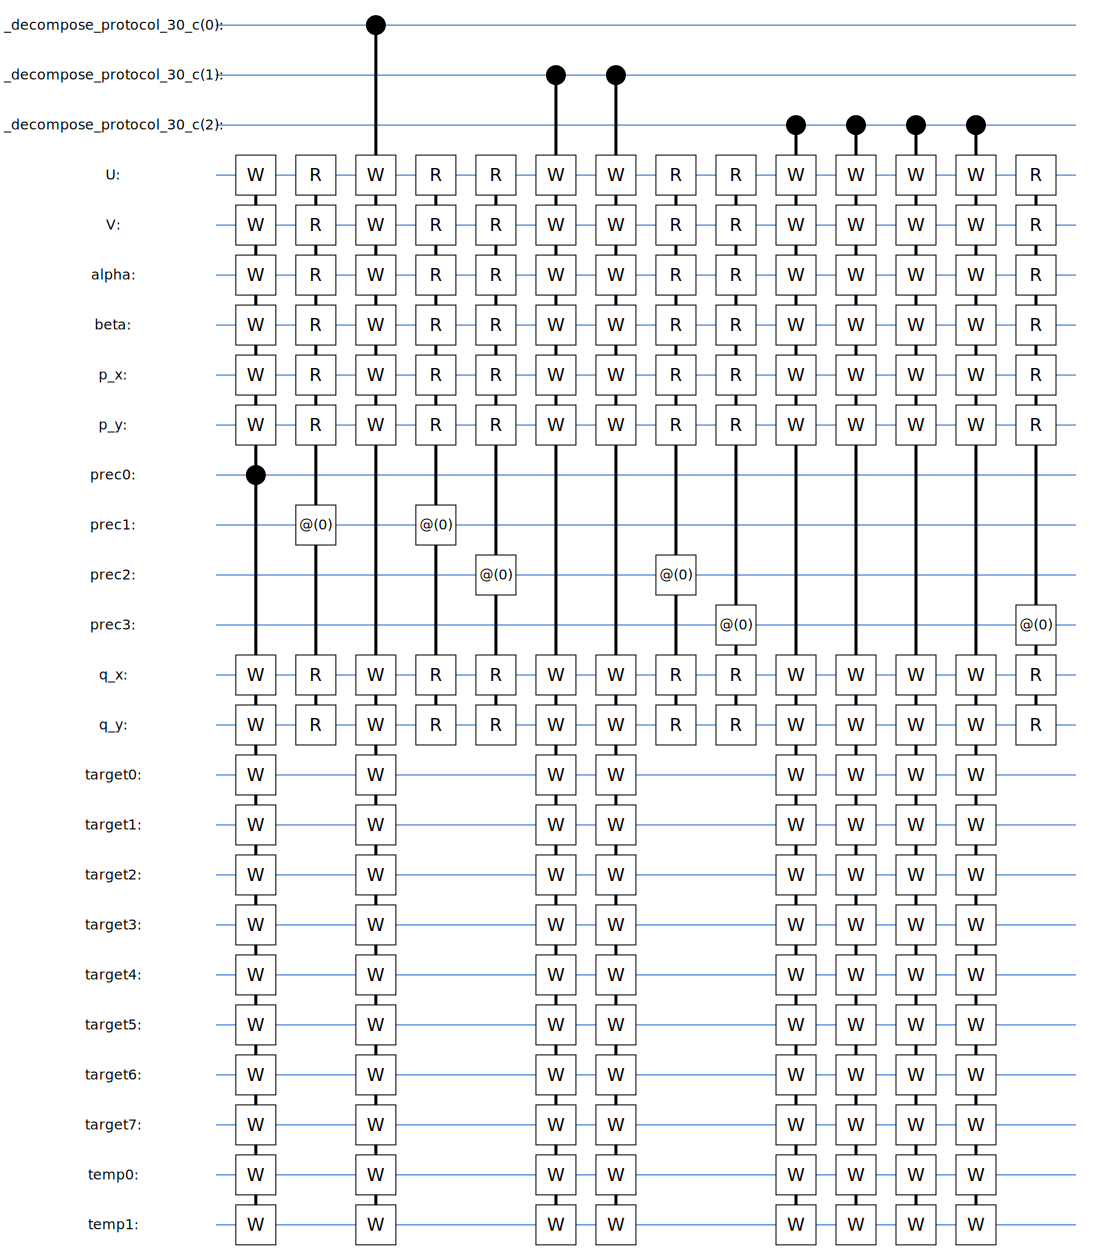

In [13]:
svg_circuit (circuit_decompose_multi(gate_gsee.circuit,1) )

<h4><b>4.2. GSEE Calculations: Scaling Analysis </b></h4> 

We will now estimate the cost of GSEE for "utility-scale" Fermi-Hubbard instances, particularly those that extend beyond the frontier of approximate classical methods ($N=20$).  Our preceding examples  specified a fixed number of precision bits for the GSEE calculation.  We can instead specify a tolerance (`eps=`) for the error in eigenvalue estimation, which is more useful in practice. The relative error in energy  will be taken as `eps = 1e-3`, which is suitable for many physical problems. 


<b>WARNING:</b> <i>The calculation block below can take roughly two hours to execute.  Precomputed outputs are provided after the block.</i>



In [14]:

# t_count         =   []
# logical_qubits  =   []

# problem_scales = list([2**n for n in range(2,12)])
# problem_qubits = 2*np.array(problem_scales)**2
# times          = 10.0*np.array(problem_scales)

# eps=np.abs(J)*1e-3      # 0.1 percent error in energy

# for N in problem_scales:

#     model  =  getInstance('FermiHubbard',shape=(N,N), J=-1.0, U=4.0,cell=SquareLattice)

#     gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.FermiHubbardSquare),
#                                             instance=model,eps=eps )

#     estimate = estimate_resources( gate_gsee )

#     t_count.append( estimate['T'] )
#     logical_qubits.append( estimate['LogicalQubits'] )



In [15]:
## Precomputed data
##

problem_scales  =  [ 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048 ]
problem_qubits  =  [ 32, 128,   512,  2048,  8192, 32768, 131072, 524288, 2097152, 8388608 ]
logical_qubits  =  [ 58, 160, 549, 2091, 8240, 32821, 131131, 524352, 2097221, 8388683]
t_count         =  [ 3331016, 22087192, 109217872, 1452018560, 10979380824, 86417346928, 1376618812896, 10999826487704, 87971063668112, 1407418101670720]

The overall $T$-count of this method should scale as $O(N^2)$ and the logical qubit count as $N + O(N^3)$.  We can verify this using our data (<b>TODO: add fits and scaling beyond non-leading order.</b>):

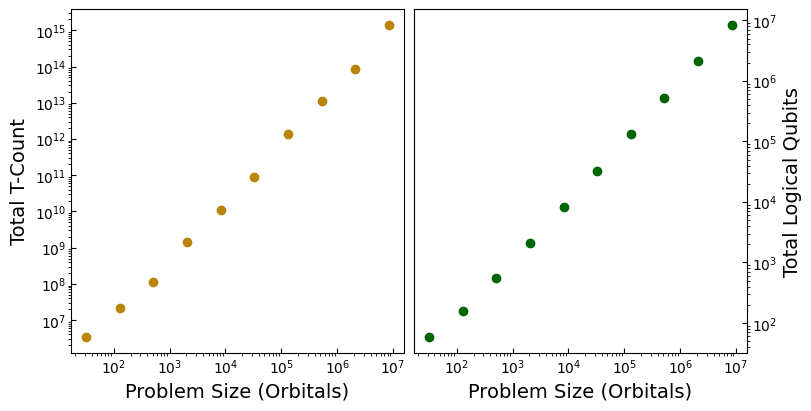

In [16]:
N_domain    =  np.linspace(problem_qubits[0],problem_qubits[-1], 100)

fig,ax = plt.subplots(1, 2, sharex=True,layout='constrained', figsize=(8, 4))

#ax[0].loglog(N_domain, fit_func_t_count(N_domain),linewidth=2,color='goldenrod')
ax[0].loglog(problem_qubits,t_count,'o',color='darkgoldenrod')
ax[0].tick_params(direction="in")
ax[0].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[0].set_ylabel('Total T-Count',fontsize=14);

#ax[1].loglog(N_domain, fit_func_logical_qubits(N_domain),linewidth=2,color='darkseagreen')
ax[1].loglog(problem_qubits,logical_qubits,'o',color='darkgreen')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(direction="in")
ax[1].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[1].set_ylabel('Total Logical Qubits',fontsize=14);


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [7]:
N_prec = 4
eps    = 1e-3

gate_gsee = QubitizedPhaseEstimation( getEncoding(VALID_ENCODINGS.FermiHubbardSquare),
                                      instance=model,prec=N_prec )

for ctr,line in enumerate(openqasm(gate_gsee.circuit,rotation_allowed=False)):
    print(line)
    if ctr > 100:
        break

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [U, V, _ancilla_0, _ancilla_1, _ancilla_2, _ancilla_3, _ancilla_4, _ancilla_5, _ancilla_6, _ancilla_7, _ancilla_8, _ancilla_9, _ancilla_10, _ancilla_11, _ancilla_12, _ancilla_13, _ancilla_14, _ancilla_15, _ancilla_16, _ancilla_17, _ancilla_18, _ancilla_19, _ancilla_20, _ancilla_21, _ancilla_22, _ancilla_23, _ancilla_24, _ancilla_25, _ancilla_26, _ancilla_27, _ancilla_28, _ancilla_29, _ancilla_30, _ancilla_31, _ancilla_32, _ancilla_33, _ancilla_34, _ancilla_35, _ancilla_36, _ancilla_37, _ancilla_38, _ancilla_39, _ancilla_40, _ancilla_41, _ancilla_42, _ancilla_43, _ancilla_44, _ancilla_45, _ancilla_46, _ancilla_47, _ancilla_48, _ancilla_49, _ancilla_50, _ancilla_51, _ancilla_52, _ancilla_53, _ancilla_54, _ancilla_55, _ancilla_56, _ancilla_57, _ancilla_58, _ancilla_59, _ancilla_60, _ancilla_61, _ancilla_62, _ancilla_63, _ancilla_64, _ancilla_65, _ancilla_66, _ancilla_67, _ancilla_68, _ancilla_